## 통계적 분석

- 상관관계가 큰 변수 찾기
- 결측치 처리
- 이상치 처리
- 로그 변환

### 데이터 (주택가격 예측 데이터)
- 아래 캐글 데이터를 다운받는다.
  https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

- https://medium.com/mighty-data-science-bootcamp/eda-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%84%A4%EB%AA%85%EC%84%9C%EC%97%90%EC%84%9C-%EC%8B%9C%EC%9E%91%ED%95%98%EA%B8%B0-230060b9fc17

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [3]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### 특성값 설명
- see https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [4]:
df_train.shape

(1460, 81)

### Target (목적변수) 의 특성 파악

In [5]:
# 목적 변수의 통계적 특성
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

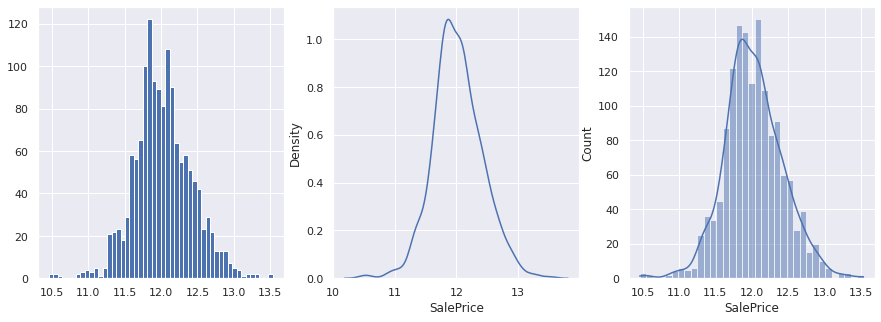

In [77]:
# 3 different ways to explore data distributions
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(df_train['SalePrice'], bins=50)

plt.subplot(1,3,2)
sns.kdeplot(df_train['SalePrice'])

plt.subplot(1,3,3)
sns.histplot(df_train['SalePrice'], kde=True); # kde - kernel density estimation
plt.show()

#### 다음과 같은 특성을 발견할 수 있다.

- Deviate from the normal distribution
- Have appreciable positive skewness
- Show peakedness

- 첨도: 뾰족한 정도가 표준정규뷴포와 같으며, 0 보다 크면 그보다 더 뾰족함.
  (관측치들이 어느 정도 집중적으로 중심에 몰려 있는가를 측정할 때 사용)
  - 첨도값(K)이 3에 가까우면 산포도가 정규분포에 가깝다. 
  - 3보다 작을 경우에는(K<3) 정규분포보다 더 완만하게 납작한 분포로 판단할 수 있으며, 
  - 첨도값이 3보다 큰 양수이면(K>3) 산포는 정규분포보다 더 뾰족한 분포로 생각할 수 있다

In [7]:
#skewness and kurtosis (kurto'sis)
print("Skewness: {:f}".format(df_train['SalePrice'].skew()))
print("Kurtosis: {:f}".format(df_train['SalePrice'].kurt()))

Skewness: 1.882876
Kurtosis: 6.536282


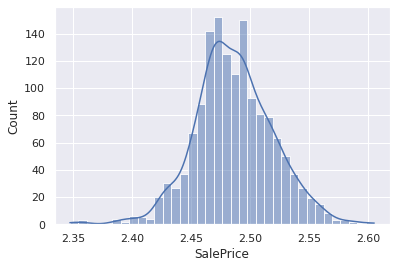

In [78]:
sns.histplot(np.log(df_train['SalePrice']), kde=True)  # log-normal dist

### 어떤 변수들이 목적변수와 연관성이 높은가? 
- 변수들간의 상관 관계는 correlation (상관관계) 을 보면 알 수 있다. 
- 상관관계를 보기 전에 먼저 target 과 특정 변수와의 관계를 보고 싶다면...

In [9]:
# 산포도를 통해 grlivarea 와 saleprice 의 관계를 보자
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.head(2)

SalePrice  GrLivArea
0     208500       1710
1     181500       1262

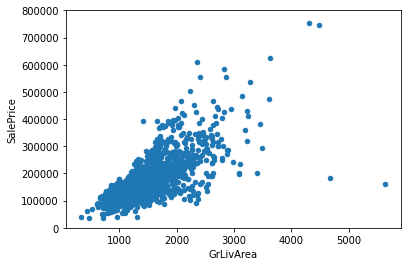

In [10]:
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [11]:
# plt.scatter 로도 그릴 수 있다.
# data[var].shape, data.SalePrice.shape
# plt.scatter(data[var], data.SalePrice);

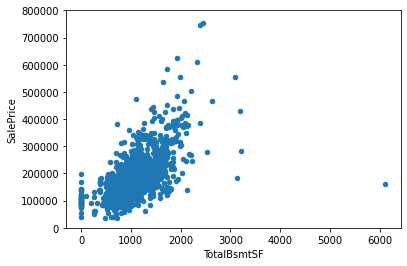

In [12]:
# scatter plot for totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

### 카테고리 변수와의 관계: 박스플롯으로 보면 편리

In [13]:
print(df_train.shape)
print(df_train['OverallQual'].unique())
print(set(df_train['OverallQual']))
df_train['OverallQual'].value_counts()

(1460, 81)
[ 7  6  8  5  9  4 10  3  1  2]
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

In [14]:
print(df_train['GarageCars'].unique())
df_train['GarageCars'].value_counts()

[2 3 1 0 4]


2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

In [15]:
# 박스플롯 overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1) 
data.head(2)

SalePrice  OverallQual
0     208500            7
1     181500            6

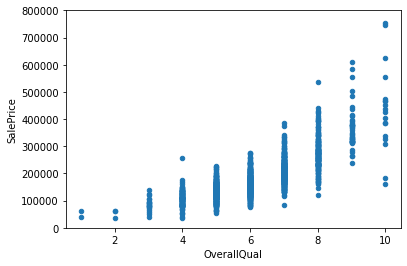

In [16]:
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

### scatter plot 보다는 boxplot 으로 보는 게 좋을 듯...
- df.polt.box() 도 있지만 받아들이는 데이터의 형태가 다름 (dataframe manual 참고)

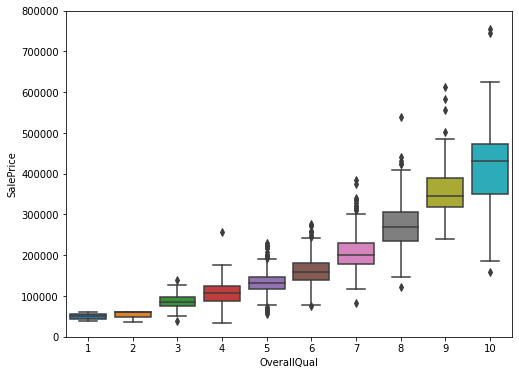

In [17]:
# f, ax = plt.subplots(figsize=(8, 6))
plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

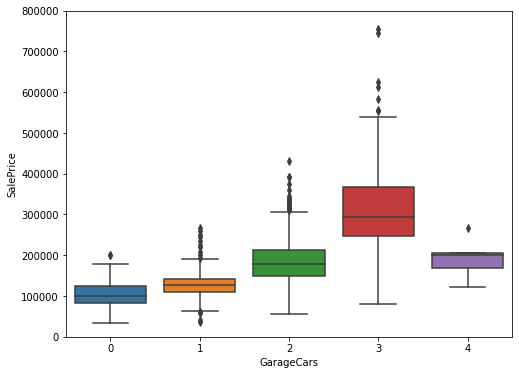

In [18]:
var = 'GarageCars'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1) # axis=0 은 위아래로 추가.
data.head()
plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

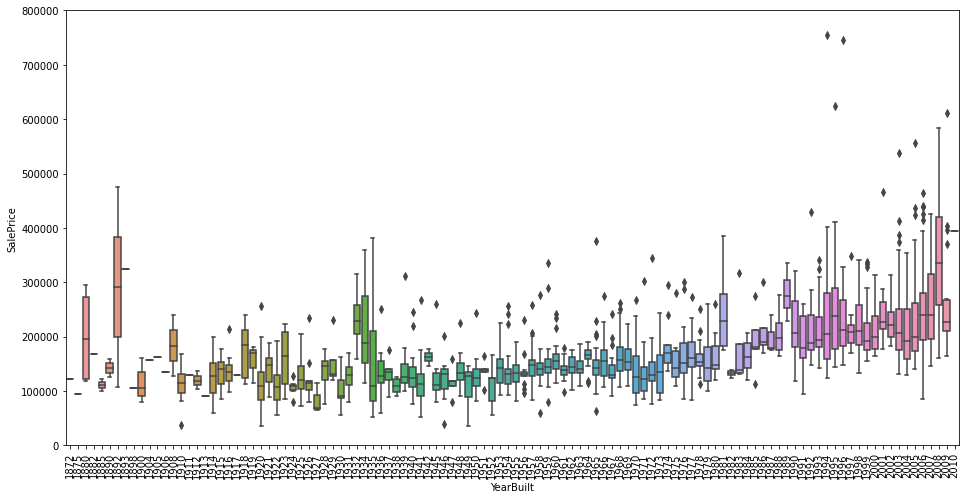

In [19]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

약한 관련성이 있으며 최근의 주택 가격이 높다. 인플레이션이 반영된 가격일 수도 있다.
유용한 특성을 선택하는 것이 문제이다. 이러한 특성 선택을 임의로 주관적으로 수행하는 것은 한계가 있다. 객관적인 방법이 필요하다.

### 객관적으로 판단하는 방법으로는...
- Correlation matrix (heatmap style).
- 'SalePrice' correlation matrix (zoomed heatmap style).
- Scatter plots between the most correlated variables

In [20]:
len(df_train.dtypes[df_train.dtypes != 'object'])   # no. of numerical features

38

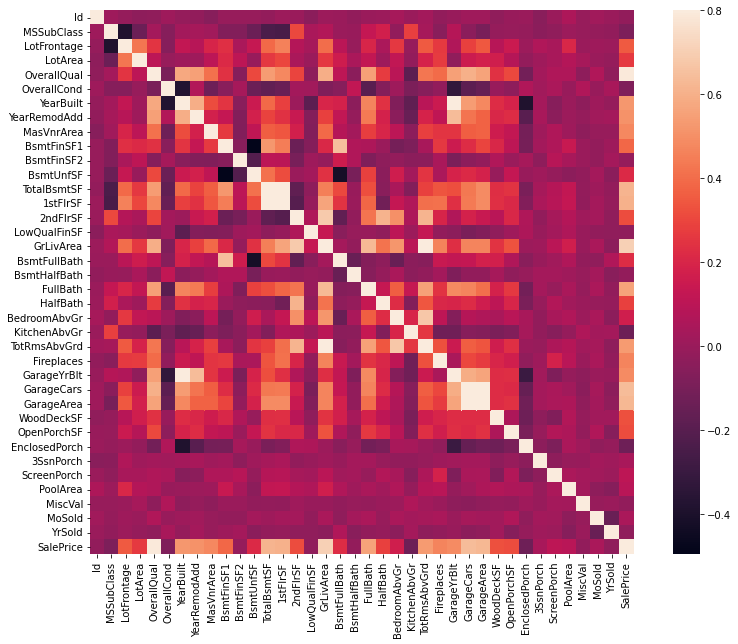

In [21]:
## correlation matrix
corrmat = df_train.corr()

f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corrmat, vmax=.8, square=True);

히트맵 타입의 상관관계 지도는 유용하다. 그림을 보면 'TotalBsmtSF', '1stFlrSF', 'GarageX' 등의 상관관계가 큰 것을 알 수 있다. 경우에 따라서는 두개의 특성이 거의 동일한 정보를 포함하는 것도 있다.

가장 중요한 것은 'SalePrice'와의 상관관계이다. 이를 보면 'GrLivArea', 'TotalBsmtSF', 'OverallQual'가 관련이 많은 것을 알 수 있다. 다른 특성들도 일부 관련이 있으므로 무시할 수 없다.

#### 'SalePrice' correlation matrix (zoomed heatmap style)

In [22]:
corrmat.head()

Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
Id           1.000000    0.011156    -0.010601 -0.033226    -0.028365   
MSSubClass   0.011156    1.000000    -0.386347 -0.139781     0.032628   
LotFrontage -0.010601   -0.386347     1.000000  0.426095     0.251646   
LotArea     -0.033226   -0.139781     0.426095  1.000000     0.105806   
OverallQual -0.028365    0.032628     0.251646  0.105806     1.000000   

             OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
Id              0.012609  -0.012713     -0.021998   -0.050298   -0.005024   
MSSubClass     -0.059316   0.027850      0.040581    0.022936   -0.069836   
LotFrontage    -0.059213   0.123349      0.088866    0.193458    0.233633   
LotArea        -0.005636   0.014228      0.013788    0.104160    0.214103   
OverallQual    -0.091932   0.572323      0.550684    0.411876    0.239666   

             ...  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
Id           ...   -0.029643    -0.000477       0.002889  -0.046635   
MSSubClass   ...   -0.012579    -0.006100      -0.012037  -0.043825   
LotFrontage  ...    0.088521     0.151972       0.010700   0.070029   
LotArea      ...    0.171698     0.084774      -0.018340   0.020423   
OverallQual  ...    0.238923     0.308819      -0.113937   0.030371   

             ScreenPorch  PoolArea   MiscVal    MoSold    YrSold  SalePrice  
Id              0.001330  0.057044 -0.006242  0.021172  0.000712  -0.021917  
MSSubClass     -0.026030  0.008283 -0.007683 -0.013585 -0.021407  -0.084284  
LotFrontage     0.041383  0.206167  0.003368  0.011200  0.007450   0.351799  
LotArea         0.043160  0.077672  0.038068  0.001205 -0.014261   0.263843  
OverallQual     0.064886  0.065166 -0.031406  0.070815 -0.027347   0.790982  

[5 rows x 38 columns]

In [23]:
corrmat.sort_values(by='SalePrice', ascending=False).T.tail()   # just for checking

SalePrice  OverallQual  GrLivArea  GarageCars  GarageArea  \
PoolArea    0.092404     0.065166   0.170205    0.020934    0.061047   
MiscVal    -0.021190    -0.031406  -0.002416   -0.043080   -0.027400   
MoSold      0.046432     0.070815   0.050240    0.040522    0.027974   
YrSold     -0.028923    -0.027347  -0.036526   -0.039117   -0.027378   
SalePrice   1.000000     0.790982   0.708624    0.640409    0.623431   

           TotalBsmtSF  1stFlrSF  FullBath  TotRmsAbvGrd  YearBuilt  ...  \
PoolArea      0.126053  0.131525  0.049604      0.083757   0.004950  ...   
MiscVal      -0.018479 -0.021096 -0.014290      0.024763  -0.034383  ...   
MoSold        0.013196  0.031372  0.055872      0.036907   0.012398  ...   
YrSold       -0.014969 -0.013604 -0.019669     -0.034516  -0.013618  ...   
SalePrice     0.613581  0.605852  0.560664      0.533723   0.522897  ...   

           BsmtFinSF2  BsmtHalfBath   MiscVal        Id  LowQualFinSF  \
PoolArea     0.041709      0.020025  0.029669  0.057044      0.062157   
MiscVal      0.004940     -0.007367  1.000000 -0.006242     -0.003793   
MoSold      -0.015211      0.032873 -0.006495  0.021172     -0.022174   
YrSold       0.031706     -0.046524  0.004906  0.000712     -0.028921   
SalePrice   -0.011378     -0.016844 -0.021190 -0.021917     -0.025606   

             YrSold  OverallCond  MSSubClass  EnclosedPorch  KitchenAbvGr  
PoolArea  -0.059689    -0.001985    0.008283       0.054203     -0.014525  
MiscVal    0.004906     0.068777   -0.007683       0.018361      0.062341  
MoSold    -0.145721    -0.003511   -0.013585      -0.028887      0.026589  
YrSold     1.000000     0.043950   -0.021407      -0.009916      0.031687  
SalePrice -0.028923    -0.077856   -0.084284      -0.128578     -0.135907  

[5 rows x 38 columns]

In [24]:
# saleprice correlation matrix
# df.nlargest(): Get the rows of a DataFrame sorted by the n largest values of columns.
k = 5      #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice'); cols

Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
SalePrice   -0.021917   -0.084284     0.351799  0.263843     0.790982   
OverallQual -0.028365    0.032628     0.251646  0.105806     1.000000   
GrLivArea    0.008273    0.074853     0.402797  0.263116     0.593007   
GarageCars   0.016570   -0.040110     0.285691  0.154871     0.600671   
GarageArea   0.017634   -0.098672     0.344997  0.180403     0.562022   

             OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
SalePrice      -0.077856   0.522897      0.507101    0.477493    0.386420   
OverallQual    -0.091932   0.572323      0.550684    0.411876    0.239666   
GrLivArea      -0.079686   0.199010      0.287389    0.390857    0.208171   
GarageCars     -0.185758   0.537850      0.420622    0.364204    0.224054   
GarageArea     -0.151521   0.478954      0.371600    0.373066    0.296970   

             ...  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
SalePrice    ...    0.324413     0.315856      -0.128578   0.044584   
OverallQual  ...    0.238923     0.308819      -0.113937   0.030371   
GrLivArea    ...    0.247433     0.330224       0.009113   0.020643   
GarageCars   ...    0.226342     0.213569      -0.151434   0.035765   
GarageArea   ...    0.224666     0.241435      -0.121777   0.035087   

             ScreenPorch  PoolArea   MiscVal    MoSold    YrSold  SalePrice  
SalePrice       0.111447  0.092404 -0.021190  0.046432 -0.028923   1.000000  
OverallQual     0.064886  0.065166 -0.031406  0.070815 -0.027347   0.790982  
GrLivArea       0.101510  0.170205 -0.002416  0.050240 -0.036526   0.708624  
GarageCars      0.050494  0.020934 -0.043080  0.040522 -0.039117   0.640409  
GarageArea      0.051412  0.061047 -0.027400  0.027974 -0.027378   0.623431  

[5 rows x 38 columns]

In [25]:
cols = cols.index; cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea'], dtype='object')

In [26]:
df_train[cols].values

array([[208500,      7,   1710,      2,    548],
       [181500,      6,   1262,      2,    460],
       [223500,      7,   1786,      2,    608],
       ...,
       [266500,      7,   2340,      1,    252],
       [142125,      5,   1078,      1,    240],
       [147500,      5,   1256,      1,    276]])

In [27]:
df_train[cols].corr()   # dataframe

SalePrice  OverallQual  GrLivArea  GarageCars  GarageArea
SalePrice     1.000000     0.790982   0.708624    0.640409    0.623431
OverallQual   0.790982     1.000000   0.593007    0.600671    0.562022
GrLivArea     0.708624     0.593007   1.000000    0.467247    0.468997
GarageCars    0.640409     0.600671   0.467247    1.000000    0.882475
GarageArea    0.623431     0.562022   0.468997    0.882475    1.000000

In [28]:
cm = df_train[cols].corr().values  # array
cm

array([[1.        , 0.7909816 , 0.70862448, 0.6404092 , 0.62343144],
       [0.7909816 , 1.        , 0.59300743, 0.60067072, 0.56202176],
       [0.70862448, 0.59300743, 1.        , 0.46724742, 0.46899748],
       [0.6404092 , 0.60067072, 0.46724742, 1.        , 0.88247541],
       [0.62343144, 0.56202176, 0.46899748, 0.88247541, 1.        ]])

In [29]:
# same as the above (numpy 에도 동일 기능 함수가 있음)
cm2 = np.corrcoef(df_train[cols].values.T) # Return correlation coefficients.
                                           # Each row of x represents a variable, and 
                                           # each column a single observation of variables
cm2

array([[1.        , 0.7909816 , 0.70862448, 0.6404092 , 0.62343144],
       [0.7909816 , 1.        , 0.59300743, 0.60067072, 0.56202176],
       [0.70862448, 0.59300743, 1.        , 0.46724742, 0.46899748],
       [0.6404092 , 0.60067072, 0.46724742, 1.        , 0.88247541],
       [0.62343144, 0.56202176, 0.46899748, 0.88247541, 1.        ]])

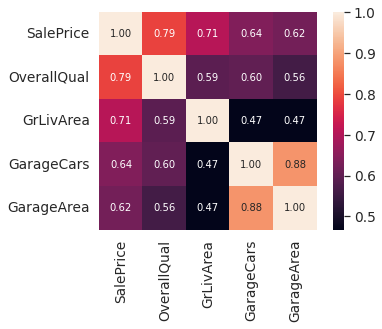

In [30]:
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
        fmt='.2f', annot_kws={'size': 10}, 
        yticklabels=cols.values, xticklabels=cols.values)
plt.show()

상관관계가 높은 순으로 정렬했다.

* 'OverallQual', 'GrLivArea' and 'TotalBsmtSF'은 'SalePrice'와 상관관계가 크다.
* 'GarageCars' and 'GarageArea' 특성은 같은 의미를 갖는 것으로 보인다 (상관관계 0.88).
* 'TotalBsmtSF' and '1stFloor' 도 상관관계가 크다. (0.82)
* 'FullBath'?? Really? 
* 'TotRmsAbvGrd' and 'GrLivArea' 도 상관관계가 크다(0.83).

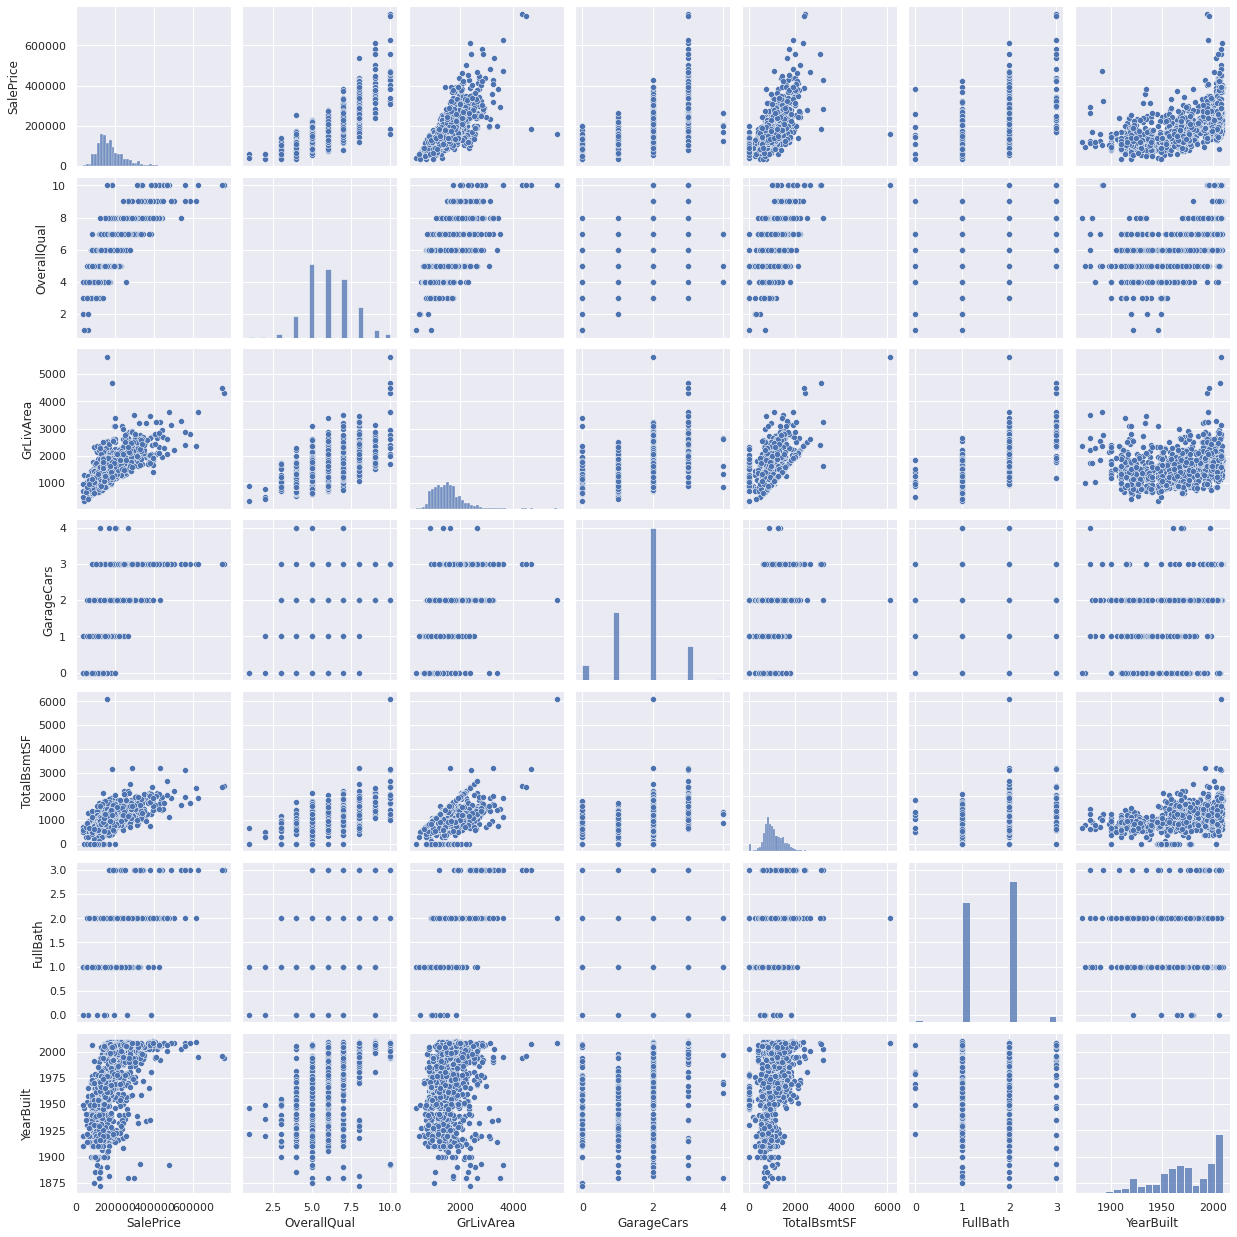

In [31]:
# 산포도
sns.set()  # default set
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 
  'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

'TotalBsmtSF' and 'GrLiveArea'이 의미 있게 보인다. 산포도를 보면 직선의 한 쪽에 집중해서 나타나는 것을 알 수 있다. 지하실의 크기는 1층의 면적과 거의 같거나 작다.

'YearBuilt'도 약한 지수함수 형태를 보인다. 가격이 계속 오르고 있다.

# 결측치 처리 (Missing Values)

결측 패턴이 산발적인가, 규칙적인가?

In [32]:
#### 참고
# df_train.isnull()
# df_train.isnull().sum()
# df_train.count()          # number of non-null elements
# df_train.isnull().sum().sort_values(ascending=False)
# df_train.isna().count(), len(df_train)

In [33]:
df_train.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [34]:
df_train.count()  # Count non-NA cells for each column or row

Id               1460
MSSubClass       1460
MSZoning         1460
LotFrontage      1201
LotArea          1460
                 ... 
MoSold           1460
YrSold           1460
SaleType         1460
SaleCondition    1460
SalePrice        1460
Length: 81, dtype: int64

In [35]:
# missing data (아래 코드는 결측치 통계를 찾는 코드이다.)
total = df_train.isnull().sum().sort_values(ascending=False)
total.head(10)

# percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.shape[0]).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
GarageCond       81  0.055479
GarageType       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtCond         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Id                0  0.000000

### 분석 결과
- 결측률이 15% 이상이면 이 특성은 제외하고 분석하는 것이 타당하다.('PoolQC', 'MiscFeature', 'Alley' 등) 이러한 데이터의 중요도도 생각해봐야 한다. 

- 'Garage*X*'의 결측치 비율이 같고, 중복성이 있다.'Bsmt*X*' 특성도 마찬가지

- 'MasVnrArea' and 'MasVnrType'는'YearBuilt'나 'OverallQual' 와 상관과계가 크므로 중복성이 있어 제외 가능하다.

- 'Electrical'는 한 값만 결측이므로 해당 샘플만 제거한다.

- 'Electrical' 외의 결측치를 관찰한 결과 모두 특성에서 제외하기로 한다. 

In [36]:
df_train_org = df_train.copy()    # 만일을 위해서 (나중에 비교해 볼 필요가 있을때)

In [37]:
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index, 1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

df_train.isnull().sum().max()            # nul 합의 최고가 0 인지 확인

0

In [38]:
df_train_org.shape

(1460, 81)

In [39]:
df_train.shape    # 18 개 columns , 1 row 제거

(1459, 63)

# 특이값(outlier)

중요한 의미나 정보를 포함할 수 있다. 표준편차나 산포도에서 찾을 수 있다.

표준 정규화를 하여 비교한다. 상위 영역에 7 이상의 표준편차 차이가 있는 것을 알 수 있다.

In [40]:
# saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis])
# saleprice_scaled

saleprice_scaled = StandardScaler().fit_transform(np.array(df_train['SalePrice']).reshape(-1,1))
saleprice_scaled

array([[ 0.34704187],
       [ 0.0071701 ],
       [ 0.53585953],
       ...,
       [ 1.07713679],
       [-0.48847623],
       [-0.42081658]])

In [41]:
saleprice_scaled[:,0]

array([ 0.34704187,  0.0071701 ,  0.53585953, ...,  1.07713679,
       -0.48847623, -0.42081658])

In [42]:
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]

print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


In [43]:
## exercise: for newaxis - to increase the dimension
print(df_train['SalePrice'].shape)
print(type(df_train['SalePrice']))     # series
df_train['SalePrice'].head()

(1459,)
<class 'pandas.core.series.Series'>


0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

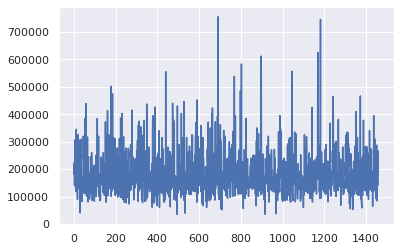

In [44]:
plt.plot(df_train['SalePrice'])   # if not shown, x-axis is default len(y)

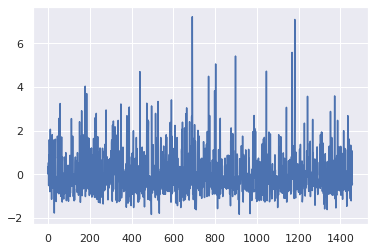

In [45]:
plt.plot(saleprice_scaled)

In [46]:
# exercise: newaxis (축을 새로 추가하기)
import numpy as np
x = np.array([1,2,3,4])
print(x, x.shape)
print(x[:,np.newaxis].shape)   # (4,) -> (4,1), x.reshape(4,1) 와 동일
print(x[np.newaxis,:].shape)  #  x.reshape(1,4) 와 동일

[1 2 3 4] (4,)
(4, 1)
(1, 4)


### Bivariate 분석

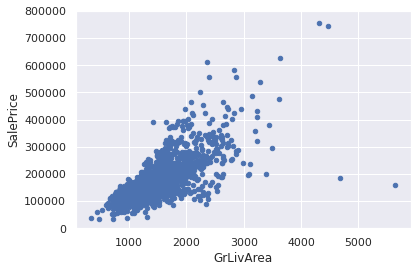

In [47]:
# bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)

data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

우측의 두 점은 트렌드를 따르지 않는 값으로 여기서는 삭제한다. 상위의 두 점은 7~ 값을 갖는 케이스인데 트렌드를 따르므로 삭제하지 않는다.

In [48]:
#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour  \
1298  1299          60       RL    63887   Pave      IR3         Bnk   
523    524          60       RL    40094   Pave      IR1         Bnk   

     Utilities LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch  \
1298    AllPub    Corner       Gtl  ...             0         0           0   
523     AllPub    Inside       Gtl  ...             0         0           0   

     PoolArea MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
1298      480       0       1    2008       New        Partial    160000  
523         0       0      10    2007       New        Partial    184750  

[2 rows x 63 columns]

In [49]:
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

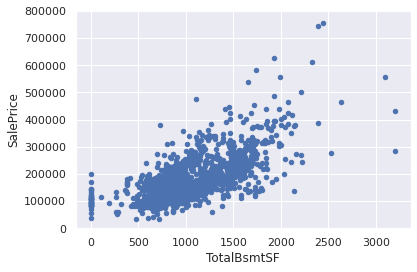

In [50]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

우측의 이상치가 있어 보이지만 그대로 둔다.

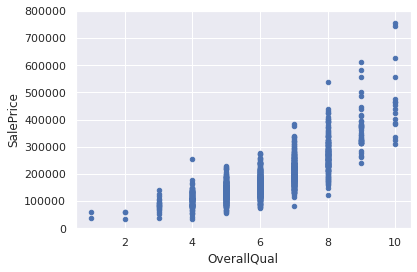

In [51]:
# bivariate analysis saleprice/overallqual
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

# 다음 단계

점검할 사항:

- 정규성
- 등분산성
- 선형관계성
- 상호 연관된 오류의 부재

### In the search for normality

- 히스토그램: Kurtosis and skewness (첨도 및 왜도) 점검
- Normal probability plot

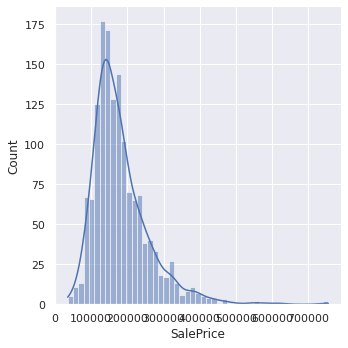

<Figure size 432x288 with 0 Axes>

In [52]:
# 히스토그램과 정규분포 플롯
sns.displot(df_train['SalePrice'], kde=True);  #  plot the estimated PDF over the data.
fig = plt.figure()

'SalePrice'는 정규분포는 아니다. 정점(peakedness)이 존재하고 양의 왜곡(positive skewness)를 보인다. 양의 왜곡에는 로그 변환을 하면 도움이 된다. 

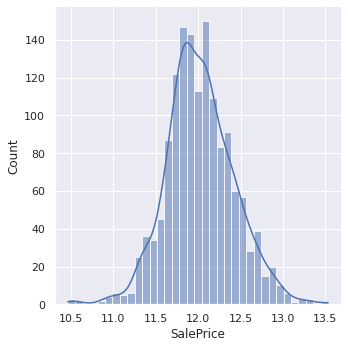

<Figure size 432x288 with 0 Axes>

In [53]:
# 로그변환
df_train['SalePrice'] = np.log(df_train['SalePrice'])
sns.displot(df_train['SalePrice'], kde=True);
fig = plt.figure()

'GrLivArea'에 대해서 알아보겠다.

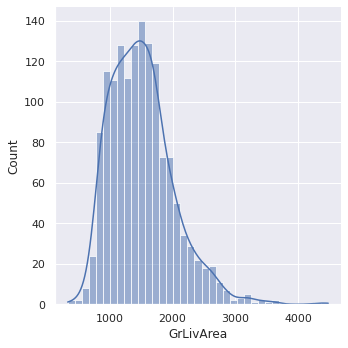

<Figure size 432x288 with 0 Axes>

In [54]:
sns.displot(df_train['GrLivArea'], kde=True);
fig = plt.figure()

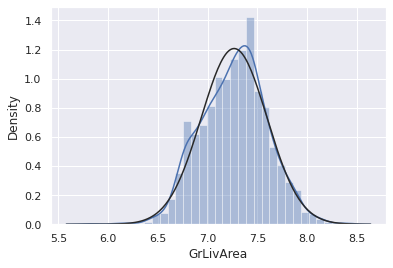

<Figure size 432x288 with 0 Axes>

In [55]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()

TotalBsmtSF 변수에 대한 그래프

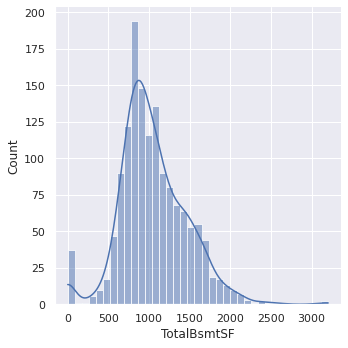

<Figure size 432x288 with 0 Axes>

In [56]:
sns.displot(df_train['TotalBsmtSF'], kde=True);
fig = plt.figure()

값이 0인 것은 로그 변환을 할 수 없다. 0인 경우는 '지하실 없음' 등으로 표현하고 0 이상인 값에 대해서만 로그 변환을 할 수 있다.

In [57]:
# 별도의 컬럼 추가
# area>0 이면 1, for area==0 이면 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train.head()

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0   1          60       RL     8450   Pave      Reg         Lvl    AllPub   
1   2          20       RL     9600   Pave      Reg         Lvl    AllPub   
2   3          60       RL    11250   Pave      IR1         Lvl    AllPub   
3   4          70       RL     9550   Pave      IR1         Lvl    AllPub   
4   5          60       RL    14260   Pave      IR1         Lvl    AllPub   

  LotConfig LandSlope  ... 3SsnPorch ScreenPorch PoolArea MiscVal MoSold  \
0    Inside       Gtl  ...         0           0        0       0      2   
1       FR2       Gtl  ...         0           0        0       0      5   
2    Inside       Gtl  ...         0           0        0       0      9   
3    Corner       Gtl  ...         0           0        0       0      2   
4       FR2       Gtl  ...         0           0        0       0     12   

   YrSold  SaleType  SaleCondition  SalePrice HasBsmt  
0    2008        WD         Normal  12.247694    1457  
1    2007        WD         Normal  12.109011    1457  
2    2008        WD         Normal  12.317167    1457  
3    2006        WD        Abnorml  11.849398    1457  
4    2008        WD         Normal  12.429216    1457  

[5 rows x 64 columns]

In [58]:
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1
df_train['HasBsmt'].sample(5)

1434    1
748     1
838     1
1445    1
1449    1
Name: HasBsmt, dtype: int64

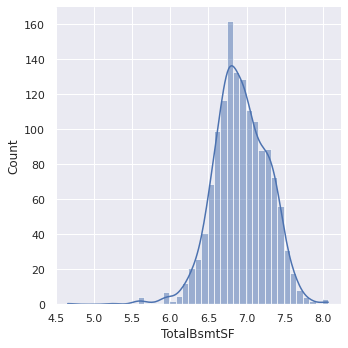

<Figure size 432x288 with 0 Axes>

In [59]:
# 양수인 경우 로그 변환
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])
# 히스토그램
sns.displot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], kde=True);
fig = plt.figure()

### homoscedasticity (동질학)
- homegeneity of variance (all RV have the same finite variance)
- 산포도로 확인할 수 있다.

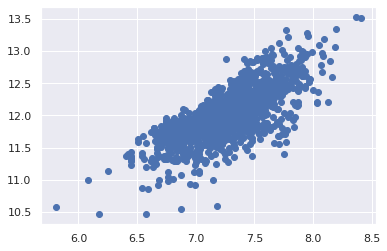

In [60]:
#scatter plot
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

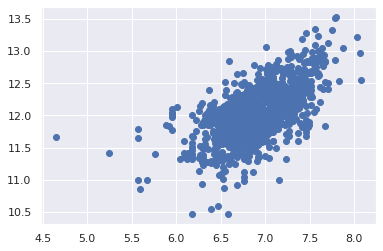

In [61]:
#scatter plot
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

# 위의 처리 이전과 이후를 비교해 보기 위해

In [62]:
df_train_org.shape, df_train.shape

((1460, 81), (1457, 64))

In [63]:
###
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
df = df_train_org.copy()
corrmat = df.corr()
corrmat.sort_values(by='SalePrice', ascending=False).T.tail()

cols = corrmat.nlargest(5, 'SalePrice') 
df2 = df[cols.index]

X, y = df2.values[:,1:], df2.values[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)
print("Before the data cleaning: ", model.score(X_test, y_test))

###
df = df_train.copy()
corrmat = df.corr()
cols = corrmat.nlargest(5, 'SalePrice') 
df3 = df[cols.index]
X, y = df3.values[:,1:], df3.values[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)
print("After the data cleaning: ", model.score(X_test, y_test))

Before the data cleaning:  0.660894978091114
After the data cleaning:  0.8076030699676444


# 모두 사용:
- int64 타입이 아닌 컬럼들은 모두 LabelEncoding() or OneHotEncoding()

In [64]:
df = df_train.copy()
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'GarageArea',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice', 'HasBsmt'],
      dtype='object')

In [65]:
df.head()

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0   1          60       RL     8450   Pave      Reg         Lvl    AllPub   
1   2          20       RL     9600   Pave      Reg         Lvl    AllPub   
2   3          60       RL    11250   Pave      IR1         Lvl    AllPub   
3   4          70       RL     9550   Pave      IR1         Lvl    AllPub   
4   5          60       RL    14260   Pave      IR1         Lvl    AllPub   

  LotConfig LandSlope  ... 3SsnPorch ScreenPorch PoolArea MiscVal MoSold  \
0    Inside       Gtl  ...         0           0        0       0      2   
1       FR2       Gtl  ...         0           0        0       0      5   
2    Inside       Gtl  ...         0           0        0       0      9   
3    Corner       Gtl  ...         0           0        0       0      2   
4       FR2       Gtl  ...         0           0        0       0     12   

   YrSold  SaleType  SaleCondition  SalePrice HasBsmt  
0    2008        WD         Normal  12.247694       1  
1    2007        WD         Normal  12.109011       1  
2    2008        WD         Normal  12.317167       1  
3    2006        WD        Abnorml  11.849398       1  
4    2008        WD         Normal  12.429216       1  

[5 rows x 64 columns]

In [66]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
print(type(df.dtypes))    # series
len(df.dtypes)
df.dtypes

<class 'pandas.core.series.Series'>


Id                 int64
MSSubClass         int64
MSZoning          object
LotArea            int64
Street            object
                  ...   
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
HasBsmt            int64
Length: 64, dtype: object

In [67]:
# string 인 column 은 모두 LabelEncoder
for i in range(1, len(df.dtypes)-1):
    if df.dtypes[i] != 'int64':
        df.iloc[:,i] = LabelEncoder().fit_transform(df.iloc[:,i])

In [68]:
(df.dtypes != 'int64').sum()

0

In [69]:
X, y = df.values[:,1:-1], df.values[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)
print("Using all the featurs: ", model.score(X_test, y_test))

Using all the featurs:  0.47985981081536777


# Exercise

### skewness, kurtosis

0   -0.030866
dtype: float64 0    0.061893
dtype: float64


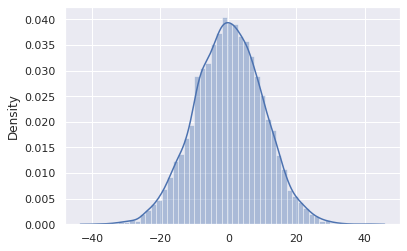

In [70]:
sample_df = pd.DataFrame(10*np.random.randn(10000,1))
sample_df.head()
print(sample_df.skew(), sample_df.kurtosis())   # excess kurtosis = kurtosis -3
sns.distplot(sample_df, color='b')

- kurtosis(첨도): b=3 정규분포, b>3 뾰족함, b<3 평평함
- skewness(왜도): a=0 정규분포, a>0 좌측치우침, a<0 우측치우침
- excess kurtosis (초과왜도): defined as kurtosis -3
- Note: The only data values (observed or observable) that contribute to kurtosis in 
  any meaningful way are those outside the region of the peak; i.e., the outliers. 
  Therefore, kurtosis measures outliers only; it measures nothing about the "peak".

### print in Puython

In [71]:
# 1. 포맷 문자열 (f-문자열)
table = {'Sjoerd': 4127, 'Jack': 4098, 'Dcab': 7678}
# table.items()              # dict.items(), dict.keys(), dict.values()
for name, phone in table.items():
    print(f'{name:7s} ==> {phone:7d}')

Sjoerd  ==>    4127
Jack    ==>    4098
Dcab    ==>    7678


In [72]:
# 2. 문자열 format 메쏘드
print('The story of {1}, {0}, and {other}.'.format('Bill', 'Manfred', other='Georg'))

The story of Manfred, Bill, and Georg.


In [73]:
# 3. 예전의 문자열 포맷팅 (use %) - sprintf() 스타일
print('%(language)s has %(number)03d quote types.' % {'language': "Python", "number": 2})

Python has 002 quote types.


### Correlation
- np.corrcoef() and df.corr()
- df.corr() is NaN tolerant whereas np.corrcoef is not.

In [74]:
a = np.array([1, 2, 3, 4, 5, np.nan])
b = np.array([2, 3, 4, 5.25, np.nan, 100])
print(np.corrcoef(a,b))
# ----
print(np.ma.masked_invalid(a),np.ma.masked_invalid(b))
np.ma.corrcoef(np.ma.masked_invalid(a), np.ma.masked_invalid(b))

[[nan nan]
 [nan nan]]
[1.0 2.0 3.0 4.0 5.0 --] [2.0 3.0 4.0 5.25 -- 100.0]


masked_array(
  data=[[1.0, 0.99838143945703],
        [0.99838143945703, 1.0]],
  mask=[[False, False],
        [False, False]],
  fill_value=1e+20)

In [75]:
a = np.array([1, 2, 3, 4, 5, np.nan])
b = np.array([2, 3, 4, 5.25, np.nan, 100])
df = pd.concat([pd.DataFrame(a), pd.DataFrame(b)], axis=1)
df.corr()

0         0
0  1.000000  0.998381
0  0.998381  1.000000

### something about pandas and numpy

- NaN is a numeric value, as defined in IEEE 754 floating-point standard. 
- None is an internal Python type (NoneType) and would be more like "inexistent" or "empty" than "numerically invalid" in this context.
- if you compute something including nan, you will get nan. But, you can not compute None.

In [119]:
np.nan + 2

nan

In [120]:
None + 2

TypeError: ignored

In [122]:
x = None        # nothing, empty, null

if x:
  print("Do you think None is True?")
elif x is False:
  print ("Do you think None is False?")
else:
  print("None is not True, or False, None is just None...")

Do you think None is True?


In [124]:
x = np.nan       # nothing, empty, null

if x:
    print("Do you think None is True?")
else:
    pass

Do you think None is True?


In [125]:
df = pd.DataFrame([[1,2,3],[None, None, 1]])    # np.nan 와 동일
df

0    1  2
0  1.0  2.0  3
1  NaN  NaN  1

In [126]:
array = np.array([[1, np.nan, 3], 
                  [4, 5, np.nan]])
pd.DataFrame(array)

0    1    2
0  1.0  NaN  3.0
1  4.0  5.0  NaN

In [127]:
print(pd.isna(array))
print(pd.isna(array[0]))

[[False  True False]
 [False False  True]]
[False  True False]


In [128]:
df = pd.DataFrame([['ant', 'bee', 'cat'], 
                   ['dog', 'cat' , 'fly']],
                 columns=['A','B','C']); df
df

A    B    C
0  ant  bee  cat
1  dog  cat  fly

In [129]:
df['A']           # column name 0 (feature), not a row index (index)

0    ant
1    dog
Name: A, dtype: object

In [130]:
df[['A','B']]

A    B
0  ant  bee
1  dog  cat

In [131]:
df[:1] == df.iloc[:1]

A     B     C
0  True  True  True

In [133]:
df['B'] == 'cat'

0    False
1     True
Name: B, dtype: bool

In [136]:
df[df['B'] == 'cat']['A']

1    dog
Name: A, dtype: object

In [138]:
df.loc[df['B'] == 'cat','A']

1    dog
Name: A, dtype: object